In [2]:
# fastdtw 패키지 설치
!pip install fastdtw
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542085 sha256=abc5aad684468ac99218f8defa4f15c61ddab0468852a2e9a710297f76ed6c32
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 26.8 MB/s eta 0:00:00


In [59]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten
from keras.preprocessing.sequence import pad_sequences
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from tslearn.metrics import dtw_path

In [3]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
df_X_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/X_train_sample100.csv')
df_y_train = pd.read_csv('/content/drive/My Drive/PhalangesOutlinesCorrect/y_train_sample100.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/X_test_sample100.csv')
df_y_test = pd.read_csv('/content/drive/MyDrive/PhalangesOutlinesCorrect/y_test_sample100.csv')

In [53]:
# DTW 거리 계산 함수
def compute_dtw_distance(series1, series2):
    distance, _ = fastdtw(series1, series2)
    return distance

# 데이터 전처리
X_train = df_X_train.values
y_train = df_y_train.values.reshape(-1)   # 1차원 배열(벡터)로 변환
X_test = df_X_test.values
y_test = df_y_test.values.reshape(-1)   # 1차원 배열(벡터)로 변환

# DTW 거리 계산하여 대칭 행렬로 표현
dtw_matrix = np.zeros((len(X_train), len(X_test)))

# DTW 거리 계산
for i, train_series in enumerate(X_train):
    for j, test_series in enumerate(X_test):
        distance = compute_dtw_distance(train_series, test_series)
        dtw_matrix[i, j] = distance

# 다수결 방식으로 예측하는 함수
def majority_vote(nearest_y_train):
    return mode(nearest_y_train, axis=1)[0].flatten()

# 각 모델에 대한 함수 정의
def knn_model(X_train, y_train, X_test):
    min_distances = []
    nearest_y_train = []

    for j in range(len(X_test)):
        test_distances = dtw_matrix[:, j]
        min_idx = np.argsort(test_distances)[:3]  # 가장 작은 거리 3개의 인덱스
        closest_y_train = y_train[min_idx]
        min_distances.append(test_distances[min_idx])
        nearest_y_train.append(closest_y_train)

    # 다수결 방식으로 예측
    pred_y = majority_vote(np.array(nearest_y_train))
    return pred_y

def logistic_regression_model(X_train, y_train, X_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model.predict(X_test)

def cart_model(X_train, y_train, X_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def xgboost_model(X_train, y_train, X_test):
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    model.fit(X_train, y_train)
    return model.predict(X_test)

def lstm_model(X_train, y_train, X_test):
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)

    return (model.predict(X_test_reshaped) > 0.5).astype(int).flatten()

def cnn_model(X_train, y_train, X_test):
    X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)

    return (model.predict(X_test_reshaped) > 0.5).astype(int).flatten()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:22:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
로지스틱 회귀 모델 성능:
모델 성능 평가:
정확도: 0.6154
F1-Score: 0.7612
Recall: 1.0000
specificity: 0.0060
혼동 행렬 (Confusion Matrix):
[[  2 330]
 [  0 526]]


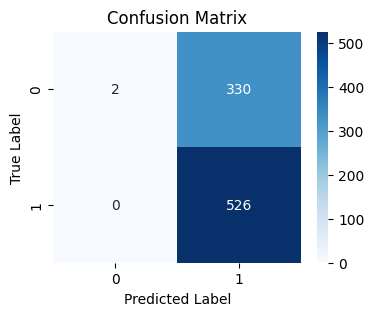

CART 모델 성능:
모델 성능 평가:
정확도: 0.6445
F1-Score: 0.7648
Recall: 0.9430
specificity: 0.1717
혼동 행렬 (Confusion Matrix):
[[ 57 275]
 [ 30 496]]


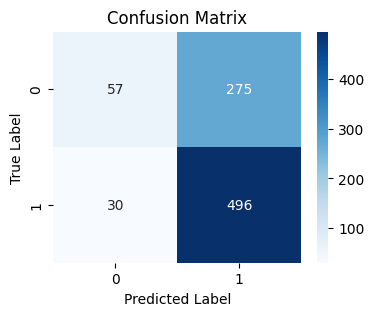

KNN 모델 성능:
모델 성능 평가:
정확도: 0.6317
F1-Score: 0.7683
Recall: 0.9962
specificity: 0.0542
혼동 행렬 (Confusion Matrix):
[[ 18 314]
 [  2 524]]


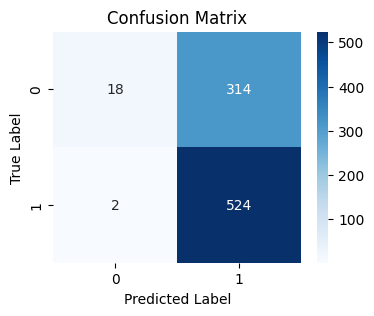

XGBoost 모델 성능:
모델 성능 평가:
정확도: 0.6259
F1-Score: 0.7659
Recall: 0.9981
specificity: 0.0361
혼동 행렬 (Confusion Matrix):
[[ 12 320]
 [  1 525]]


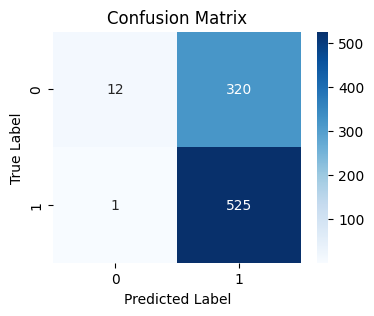

RNN-LSTM 모델 성능:
모델 성능 평가:
정확도: 0.6131
F1-Score: 0.7601
Recall: 1.0000
specificity: 0.0000
혼동 행렬 (Confusion Matrix):
[[  0 332]
 [  0 526]]


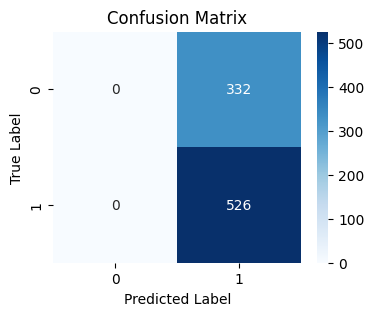

CNN 모델 성능:
모델 성능 평가:
정확도: 0.6154
F1-Score: 0.7612
Recall: 1.0000
specificity: 0.0060
혼동 행렬 (Confusion Matrix):
[[  2 330]
 [  0 526]]


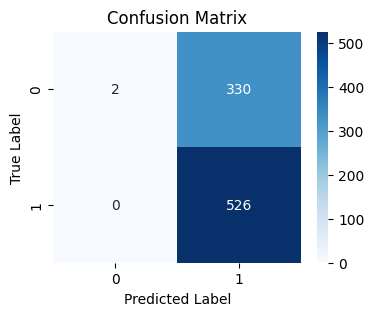

In [58]:
# 모델 선택 및 예측
# 모델 선택 및 예측
models = {
    "로지스틱 회귀": logistic_regression_model(X_train, y_train, X_test),
    "CART": cart_model(X_train, y_train, X_test),
    "KNN": knn_model(X_train, y_train, X_test),
    "XGBoost": xgboost_model(X_train, y_train, X_test),
    "RNN-LSTM": lstm_model(X_train, y_train, X_test),
    "CNN": cnn_model(X_train, y_train, X_test)
}

# 성능 평가 및 출력
for model_name, pred_y in models.items():
    accuracy = accuracy_score(y_test, pred_y)
    recall = recall_score(y_test, pred_y)
    f1 = f1_score(y_test, pred_y)
    specificity = specificity_score(y_test, pred_y)
    conf_matrix = confusion_matrix(y_test, pred_y)

    # 성능 지표 출력
    print(f"{model_name} 모델 성능:")
    print("모델 성능 평가:")
    print(f"정확도: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"specificity: {specificity:.4f}")
    print("혼동 행렬 (Confusion Matrix):")
    print(conf_matrix)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, pred_y)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()